# 10K to FCM test

- Start with the 10k
- instead of keywords, find initial company goal
  - for example, growth or profitability, etc.
- Start with the goal, G, what causes G to increase/decrease
- Also, what are the risks?
- then ask questions from there, when we find the risks/goals/whatever else (need to read those 10ks and understand what they generally talk about...) 
  - for example, if ecommerce causes growth, what helps improve ecommerce
    - these questions can come from the 10k, but maybe also come from somewhere else? What if we use Google/BIng???
- Build a model that represents how the company understands itself in relation to it's environment
- Add nodes that create causality to the company model nodes
- The causality nodes can be from other sources, like major search engines

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%pip install sklearn
%pip install torch==1.7.1
%pip install --upgrade tensorflow-gpu # for Python 3.n and GPU
%pip install --upgrade transformers>=4.0.0
%pip install tensorflow
%pip install ktrain
%pip install keybert[gensim]

In [2]:
project_name = "litia10k"
path = 'levis'

## FCM model building

- Index everything for BERT
- Start with the company goals
- Ask questions based on what comes back
  - Question depth of n

In [3]:
import ktrain
from ktrain import text
import pandas as pd

data = []

files = os.listdir(path)
for file in files:
    if os.path.isfile(os.path.join(path,file)):
        f=open(os.path.join(path,file),'r', errors='ignore') 
        data.append([f.read(),file])
        f.close()

df = pd.DataFrame(data, columns=['Text','File'])
df_text_and_filename = df.copy()
df.head(5)

,Text,File
0,Growth through acquisitions is a key component...,aquisitions.txt
1,"We seek to provide customers a seamless, blend...",businessStrategy.txt
2,Each of our stores operates under a separate a...,franchiseAgreements.txt
3,"As a company driven by our mission statement, ...",humanCapital.txt
4,Many manufacturers provide assistance in the f...,manufacurers.txt


In [4]:
fashion_data = df.Text.values.tolist()

In [5]:
# Convert to list
#fashion_data = df.Text.values.tolist()
INDEXDIR = '/tmp/lithia10kd'
text.SimpleQA.initialize_index(INDEXDIR)
text.SimpleQA.index_from_list(fashion_data, INDEXDIR, commit_every=len(fashion_data),
                              multisegment=True, procs=4, # these args speed up indexing
                               breakup_docs=True         # this slows indexing but speeds up answer retrieval
                              )
                              

## Start by asking initial questions based on company goals

In [6]:
qa = text.SimpleQA(INDEXDIR)

increase_answer_list = []
effects_answer_list = []
decrease_answer_list = []

#company_objectives = ["market share", "profitability"]
company_objectives = ["risk", "business", "financial results", "class a stock", "strategy"]

counter = 0
for k in company_objectives:
    print(k)
    try:
        increase_answer_list.append( { 
            'cause': qa.ask('What causes ' + k + ' to increase?'),
            'effect': k
        })

        increase_answer_list.append( { 
            'cause': qa.ask('What improves ' + k + '?'),
            'effect': k
        })
        decrease_answer_list.append( { 
            'cause': qa.ask('What causes ' + k + ' to decrease?'),
            'effect': k
        })

        decrease_answer_list.append( { 
            'cause': qa.ask('What adversely affects ' + k + '?'),
            'effect': k
        })

        effects_answer_list.append( { 
            'cause': qa.ask('What effects ' + k + '?'),
            'effect': k
        })

        effects_answer_list.append( { 
            'cause': qa.ask('What affects ' + k + '?'),
            'effect': k
        })

    except Exception as e:
        print("ERR: ")
        print(e) 
    #if counter > 3:
    #    break
    counter = counter + 1
    
#for i in increase_answer_list:
#    #weight = set_weight(qa.ask('How much does ' + i.cause + ' cause ' + i.effect + ' to decrease?'))
#    #fcm.setWeight(i.cause, i.effect, weight)
#    print(i['cause'], i['effect']) #, weight)

risk


business


financial results


class a stock


strategy


## Sanity check to make sure everything looks good

In [7]:
print("------------------------------------------------------------")
print("Increase answer list")
print("------------------------------------------------------------")
for i in increase_answer_list:
    print("***** effect: " + i["effect"])
    for c in i["cause"]:
        print("answer: " + c["answer"])
        print("confidence: " + str(c["confidence"]))
        print("similarity_score: " + str(c["similarity_score"]))
        print("reference: " + c["reference"])
        print("sentence_beginning: " + c["sentence_beginning"])
        print("sentence_end: " + c["sentence_end"])
        print("full_answer: " + c["full_answer"])
        print("-------------")
#print(increase_answer_list)
print("------------------------------------------------------------")
print("Decrease answer list")
print("------------------------------------------------------------")
#print(decrease_answer_list)
for i in decrease_answer_list:
    print("***** effect: " + i["effect"])
    for c in i["cause"]:
        print("answer: " + c["answer"])
        print("confidence: " + str(c["confidence"]))
        print("similarity_score: " + str(c["similarity_score"]))
        print("reference: " + c["reference"])
        print("sentence_beginning: " + c["sentence_beginning"])
        print("sentence_end: " + c["sentence_end"])
        print("full_answer: " + c["full_answer"])
        print("-------------")

print("------------------------------------------------------------")
print("Effects answer list")
print("------------------------------------------------------------")
#print(effects_answer_list)
for i in effects_answer_list:
    print("***** effect: " + i["effect"])
    for c in i["cause"]:
        print("answer: " + c["answer"])
        print("confidence: " + str(c["confidence"]))
        print("similarity_score: " + str(c["similarity_score"]))
        print("reference: " + c["reference"])
        print("sentence_beginning: " + c["sentence_beginning"])
        print("sentence_end: " + c["sentence_end"])
        print("full_answer: " + c["full_answer"])
        print("-------------")


------------------------------------------------------------
Increase answer list
------------------------------------------------------------
***** effect: risk
answer: to changing consumer preferences
confidence: 0.4255110580678318
similarity_score: 0.745736300945282
reference: 6
sentence_beginning:  we strive for diversification in our products, services, brands and geographic locations to reduce dependence on any one manufacturer, reduce susceptibility 
sentence_end: , manage market risk and maintain profitability.
full_answer: we strive for diversification in our products, services, brands and geographic locations to reduce dependence on any one manufacturer, reduce susceptibility to changing consumer preferences, manage market risk and maintain profitability.
-------------
answer: competition
confidence: 0.3894853416868995
similarity_score: 0.673542320728302
reference: 2
sentence_beginning:  
sentence_end:  the retail automotive business is highly competitive.
full_answer: compet

## Get the cause/effects and put them in a dataframe

In [39]:
def build_cause_effect_df(df_cause_effect, answer_list, effect_type):
    for i in answer_list:
        for c in i["cause"]:

            keywords = kw_model.extract_keywords(c["answer"], keyphrase_ngram_range=(1, 1), stop_words='english', 
                                top_n=5, use_mmr=True, diversity=0.7)
            keywords_bigrams = kw_model.extract_keywords(c["answer"], keyphrase_ngram_range=(1, 2), stop_words='english', 
                                top_n=5, use_mmr=True, diversity=0.7)
            keywords_trigrams = kw_model.extract_keywords(c["answer"], keyphrase_ngram_range=(1, 3), stop_words='english', 
                                top_n=5, use_mmr=True, diversity=0.7)

            all_keywords = []
            if keywords:
                all_keywords += keywords
            if keywords_bigrams:
                all_keywords += keywords_bigrams
            if keywords_trigrams:
                all_keywords += keywords_trigrams

            weight = 0
            if effect_type == "increase":
                weight = 1
            elif effect_type == "decrease":
                weight = -1
            else:
                weight = 0.5


            top_k = c["answer"]
            top_k_val = 0
            if(len(all_keywords) > 0):
                top_k = max(all_keywords, key = itemgetter(1))[0]
                top_k_val = max(all_keywords, key = itemgetter(1))[1]

            #print("Cause: " + top_k + ", Effect: " + i["effect"] + ", Original : " + c["answer"] + ", Confidence: " + str(c["confidence"]) + ", k_num: " + str(top_k_val))
            #print("------------------------------")
            if c["confidence"] > .1:
                df_cause_effect.loc[len(df_cause_effect.index)] = [top_k, i["effect"], effect_type, c["confidence"], top_k_val, all_keywords, c["similarity_score"], weight, c["full_answer"]]
    
    return df_cause_effect


In [40]:
from keybert import KeyBERT
from operator import itemgetter
import pandas as pd

df_cause_effect = pd.DataFrame(columns=['cause', 'effect', 'effect_type', 'confidence', 'top_keyword_score', 'keywords', 'similarity_score', 'weight', 'full_answer'])
kw_model = KeyBERT()

effect_type = ""

df_cause_effect = build_cause_effect_df(df_cause_effect, increase_answer_list, "increase")
df_cause_effect = build_cause_effect_df(df_cause_effect, decrease_answer_list, "decrease")
df_cause_effect = build_cause_effect_df(df_cause_effect, effects_answer_list, "effect")


print(df_cause_effect.info())
df_cause_effect.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 0 to 46
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cause              47 non-null     object 
 1   effect             47 non-null     object 
 2   effect_type        47 non-null     object 
 3   confidence         47 non-null     float64
 4   top_keyword_score  47 non-null     float64
 5   keywords           47 non-null     object 
 6   similarity_score   47 non-null     float64
 7   weight             47 non-null     object 
 8   full_answer        47 non-null     object 
dtypes: float64(3), object(6)
memory usage: 3.7+ KB
None


,cause,effect,effect_type,confidence,top_keyword_score,keywords,similarity_score,weight,full_answer
0,changing consumer preferences,risk,increase,0.425511,0.9803,"[(changing consumer, 0.8703), (preferences, 0....",0.745736,1,"we strive for diversification in our products,..."
1,competition,risk,increase,0.389485,0.0000,[],0.673542,1,competition the retail automotive business is ...
2,claims arising actual,risk,increase,0.184249,0.8200,"[(claims, 0.7541), (violations, 0.5931), (aris...",0.634113,1,claims arising out of actual or alleged violat...
3,for diversification,risk,increase,1.000000,0.0000,[],0.691431,1,"we strive for diversification in our products,..."
4,growth through acquisitions,business,increase,0.931416,0.0000,[],0.711466,1,growth through acquisitions is a key component...
5,in modernization,business,increase,0.422155,0.0000,[],0.714892,1,"in response to evolving consumer preferences, ..."
6,human capital capabilities,business,increase,0.346359,0.8482,"[(capital, 0.5884), (capabilities, 0.4638), (a...",0.662600,1,"as our business evolves, we will remain focuse..."
7,federal laws regulations,business,increase,0.230997,0.9118,"[(federal laws, 0.8892), (state, 0.5345), (reg...",0.632297,1,a number of state and federal laws and regulat...
8,reduction administrative functions,financial results,increase,0.524610,0.7741,"[(reduction administrative, 0.7591), (stores, ...",0.774589,1,the reduction of administrative functions at o...
9,new vehicle models,financial results,increase,0.288742,0.7359,"[(consumer, 0.571), (vehicle, 0.5616), (new, 0...",0.756252,1,seasonality and quarterly fluctuations in a st...


In [41]:
df_cause_effect.head(50)

,cause,effect,effect_type,confidence,top_keyword_score,keywords,similarity_score,weight,full_answer
0,changing consumer preferences,risk,increase,0.425511,0.9803,"[(changing consumer, 0.8703), (preferences, 0....",0.745736,1,"we strive for diversification in our products,..."
1,competition,risk,increase,0.389485,0.0000,[],0.673542,1,competition the retail automotive business is ...
2,claims arising actual,risk,increase,0.184249,0.8200,"[(claims, 0.7541), (violations, 0.5931), (aris...",0.634113,1,claims arising out of actual or alleged violat...
3,for diversification,risk,increase,1.000000,0.0000,[],0.691431,1,"we strive for diversification in our products,..."
4,growth through acquisitions,business,increase,0.931416,0.0000,[],0.711466,1,growth through acquisitions is a key component...
5,in modernization,business,increase,0.422155,0.0000,[],0.714892,1,"in response to evolving consumer preferences, ..."
6,human capital capabilities,business,increase,0.346359,0.8482,"[(capital, 0.5884), (capabilities, 0.4638), (a...",0.662600,1,"as our business evolves, we will remain focuse..."
7,federal laws regulations,business,increase,0.230997,0.9118,"[(federal laws, 0.8892), (state, 0.5345), (reg...",0.632297,1,a number of state and federal laws and regulat...
8,reduction administrative functions,financial results,increase,0.524610,0.7741,"[(reduction administrative, 0.7591), (stores, ...",0.774589,1,the reduction of administrative functions at o...
9,new vehicle models,financial results,increase,0.288742,0.7359,"[(consumer, 0.571), (vehicle, 0.5616), (new, 0...",0.756252,1,seasonality and quarterly fluctuations in a st...


In [48]:
df_cause_effect = df_cause_effect.drop_duplicates(['cause', 'effect'], keep=False)
print(df.info())
df_cause_effect.head(25)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 1 to 35
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cause              24 non-null     object 
 1   effect             24 non-null     object 
 2   effect_type        24 non-null     object 
 3   confidence         24 non-null     float64
 4   top_keyword_score  24 non-null     float64
 5   keywords           24 non-null     object 
 6   similarity_score   24 non-null     float64
 7   weight             24 non-null     object 
 8   full_answer        24 non-null     object 
dtypes: float64(3), object(6)
memory usage: 1.9+ KB
None


,cause,effect,effect_type,confidence,top_keyword_score,keywords,similarity_score,weight,full_answer
1,competition,risk,increase,0.389485,0.0000,[],0.673542,1,competition the retail automotive business is ...
2,claims arising actual,risk,increase,0.184249,0.8200,"[(claims, 0.7541), (violations, 0.5931), (aris...",0.634113,1,claims arising out of actual or alleged violat...
3,for diversification,risk,increase,1.000000,0.0000,[],0.691431,1,"we strive for diversification in our products,..."
4,growth through acquisitions,business,increase,0.931416,0.0000,[],0.711466,1,growth through acquisitions is a key component...
5,in modernization,business,increase,0.422155,0.0000,[],0.714892,1,"in response to evolving consumer preferences, ..."
6,human capital capabilities,business,increase,0.346359,0.8482,"[(capital, 0.5884), (capabilities, 0.4638), (a...",0.662600,1,"as our business evolves, we will remain focuse..."
8,reduction administrative functions,financial results,increase,0.524610,0.7741,"[(reduction administrative, 0.7591), (stores, ...",0.774589,1,the reduction of administrative functions at o...
9,new vehicle models,financial results,increase,0.288742,0.7359,"[(consumer, 0.571), (vehicle, 0.5616), (new, 0...",0.756252,1,seasonality and quarterly fluctuations in a st...
10,oversight consumer lending,financial results,increase,0.180542,0.9585,"[(consumer lending, 0.8344), (oversight, 0.600...",0.693003,1,"in recent years, there has been an increase in..."
11,timing acquisition,financial results,increase,0.569583,0.7651,"[(timing acquisition, 0.7651), (activity, 0.24...",0.753083,1,"the timing of our acquisition activity, which ..."


## Create an FCM with the results

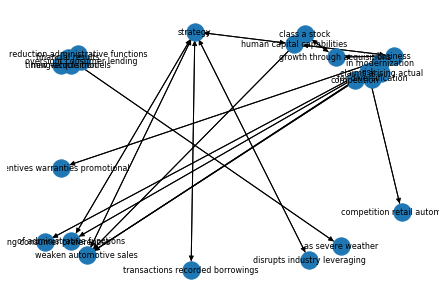

In [49]:
import networkx as nx
import matplotlib as plt

visual_graph = nx.Graph()

for i, row in df_cause_effect.iterrows():
    weight = 0
    if row["effect_type"] == "increase":
        weight = 1
    elif row["effect_type"] == "decrease":
        weight = -1
    visual_graph.add_edge(row["cause"], row["effect"], weight=weight)

pos = nx.spring_layout(visual_graph, iterations=100)
nx.draw(visual_graph.to_directed(),
        pos,
        font_size=8, with_labels=True
        )

In [50]:
import numpy as np

unique_cause = df_cause_effect['cause'].unique()
unique_effect = df_cause_effect['effect'].unique()

df_unique_cause = pd.DataFrame(unique_cause, columns=['concept'])
df_unique_effect = pd.DataFrame(unique_effect, columns=['concept'])

df_almost_unique = df_unique_cause.append(df_unique_effect)
print(len(df_almost_unique))

unique_combo = df_almost_unique['concept'].unique()

df_unique_concepts = pd.DataFrame(unique_combo, columns=['concept'])
print(len(df_unique_concepts))
df_unique_concepts.head(27)

23
23


,concept
0,competition
1,claims arising actual
2,for diversification
3,growth through acquisitions
4,in modernization
5,human capital capabilities
6,reduction administrative functions
7,new vehicle models
8,oversight consumer lending
9,timing acquisition


## Save the results to a graph-based database

The following code will save the FCM as a graph using Gremlin into Cosmos DB. Note that you need to replace the credentials for your database.

In [51]:
from datetime import datetime
import json
import http.client

right_about_now = datetime.now().strftime('%Y-%m-%dT%H:%M:%S.000Z')
v_statements = []
e_statements = []
model_name = 'lithia10kv1'

#create the vectors 
for i, row in df_unique_concepts.iterrows():
    v = "g.addV('" + row["concept"] + "').property('id','" + row["concept"] + right_about_now + "').property('modelName','" + model_name + "').property('createDate', '" + right_about_now + "');"
    v_statements.append(v)

#build out the edges
for i, row in df_cause_effect.iterrows():
    e = "g.V('" + row["cause"] + right_about_now + "').addE('affects').property('weight','" + str(row["weight"]) + "').to(g.V('" + row["effect"] + right_about_now + "'));"
    e_statements.append(e)

print(v_statements)

["g.addV('competition').property('id','competition2021-08-03T10:34:44.000Z').property('modelName','lithia10kv1').property('createDate', '2021-08-03T10:34:44.000Z');", "g.addV('claims arising actual').property('id','claims arising actual2021-08-03T10:34:44.000Z').property('modelName','lithia10kv1').property('createDate', '2021-08-03T10:34:44.000Z');", "g.addV('for diversification').property('id','for diversification2021-08-03T10:34:44.000Z').property('modelName','lithia10kv1').property('createDate', '2021-08-03T10:34:44.000Z');", "g.addV('growth through acquisitions').property('id','growth through acquisitions2021-08-03T10:34:44.000Z').property('modelName','lithia10kv1').property('createDate', '2021-08-03T10:34:44.000Z');", "g.addV('in modernization').property('id','in modernization2021-08-03T10:34:44.000Z').property('modelName','lithia10kv1').property('createDate', '2021-08-03T10:34:44.000Z');", "g.addV('human capital capabilities').property('id','human capital capabilities2021-08-03T1

In [ ]:
def send_to_cosmos(client, statements):
    for query in statements:
        print("\n> {0}\n".format(query))
        callback = client.submitAsync(query)
        if callback.result() is not None:
            print("\tInserted this vertex:\n\t{0}".format(
                callback.result().all().result()))
        else:
            print("Something went wrong with this query: {0}".format(query))
            print(callback.result())

from gremlin_python.driver import client, serializer, protocol
from gremlin_python.driver.protocol import GremlinServerError
import sys
import traceback
import nest_asyncio
nest_asyncio.apply()

client = client.Client('COSMOS_URL', 'g',
                        username="USERNAME",
                        password="YOUR_DB_PASSWORD",
                        message_serializer=serializer.GraphSONSerializersV2d0()
                        )

send_to_cosmos(client, v_statements)
send_to_cosmos(client, e_statements)